# **Get embeddings of labtests**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/ML4Health/'

Mounted at /content/drive


## Load libraries and setup environment

In [ ]:
!pip install tslearn
!pip install minisom



from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom

from datetime import timedelta
import os

import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

import bigframes.pandas as bf
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from gensim.models import Word2Vec

from IPython.display import clear_output

import torch

import copy
import datetime
import sys

bf.options.bigquery.location = "US"
bf.options.bigquery.project = 'hellobigquery-431508'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=a5acf7a2c57a88751aba8a5cb6168722c0488c7285faf6b39897bc0ccdc114a1
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [ ]:
# authenticate
auth.authenticate_user()

project_id = 'hellobigquery-431508'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
dataset = 'mimiciv'


## **Find patients with AD related ICD codes.**

Load all diagnoses icd table, and filter with our event list:

In [ ]:
query = """
  SELECT
    d.*,
    a.dischtime AS discharge_time
  FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd` AS d
  INNER JOIN
    `physionet-data.mimiciv_hosp.admissions` AS a
  ON
    d.hadm_id = a.hadm_id
  WHERE
    d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
      'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
      'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
      'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')

"""
df_ad_patients_with_discharge_time = bf.read_gbq(query)
print(len(df_ad_patients_with_discharge_time))
df_ad_patients_with_discharge_time.head(10)

# WHERE
    # d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
    # 'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
    # 'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
    # 'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679',
    # '29012', '331', '2904', '29041', '29042', '29043', '294', '2948', '2949',
    # '2941', '29411', '2942', '29421', '3312', '3316', '3317', '33111', '33119',
    # '33181', '33182', '33189', '4377', '3313', '3314', '3315', '437', '4371',
    # '4372', '4373', '4374', '4375', '4376', '4378', '4379', '33183', '331',
    # '3311' )

7420


,subject_id,hadm_id,seq_num,icd_code,icd_version,discharge_time
0,17933761,20476026,4,F0280,10,2112-11-08 12:20:00
1,14945936,26868663,5,F0391,10,2203-05-28 15:32:00
2,19865666,27925490,13,F0280,10,2152-05-14 16:57:00
3,10707442,23962945,4,F0280,10,2147-06-21 14:38:00
4,19021878,20406937,9,F0280,10,2173-02-22 13:33:00
5,12864680,21022399,14,G3183,10,2144-10-11 15:02:00
6,15380556,27064881,1,I671,10,2141-08-30 15:45:00
7,14125217,22678449,10,I672,10,2182-06-27 15:30:00
8,19454731,23586324,3,I671,10,2134-08-02 17:50:00
9,18497825,23119353,14,F0280,10,2177-01-02 11:15:00


In [ ]:
# df_ad_patients_with_discharge_time.head(10)

In [ ]:
ad_patients_list = list(df_ad_patients_with_discharge_time.drop_duplicates(subset=['subject_id'])['subject_id'])
len(ad_patients_list)
# df_ad_patients

3947

## Possible Tests

## **See what tests are taken by these patients**

In [ ]:
# See what labtests are taken for these patients

query = """
  SELECT
    d.subject_id,
    d.hadm_id,
    d.icd_code,
    d.icd_version,
    l.itemid,
    l.valuenum,
    l.valueuom,
    l.labevent_id,
    l.charttime,
    l.flag,
    dlab.label,
    dlab.fluid,
    dlab.category
  FROM
    (
      SELECT subject_id, hadm_id, icd_code, icd_version
      FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
      WHERE icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
            'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
            'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
            'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')
    ) AS d
  INNER JOIN
    (
      SELECT subject_id, hadm_id, labevent_id, itemid, valuenum, valueuom, charttime, flag
      FROM `physionet-data.mimiciv_hosp.labevents`
      WHERE lower(flag) LIKE 'abnormal%'
        OR flag IS NULL
    ) AS l
  ON
    d.subject_id = l.subject_id
    AND d.hadm_id = l.hadm_id
  INNER JOIN
    `physionet-data.mimiciv_hosp.d_labitems` AS dlab
  ON
    l.itemid = dlab.itemid
    WHERE l.valuenum IS NOT NULL  -- remove NULL values
  # WHERE (LOWER(dlab.label) LIKE '%csf' OR
  #  LOWER(dlab.label) LIKE'%b12%')
"""
df_ad_patients_lab_results = bf.read_gbq(query).sort_values(by=['subject_id', 'charttime', 'labevent_id']).reset_index(drop=True)
print(len(df_ad_patients_lab_results))
df_ad_patients_lab_results.head(10)


1385974


,subject_id,hadm_id,icd_code,icd_version,itemid,valuenum,valueuom,labevent_id,charttime,flag,label,fluid,category
0,10000084,23052089,F0280,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology
1,10000084,23052089,G3183,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology
2,10000084,23052089,F0280,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology
3,10000084,23052089,G3183,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology
4,10000084,23052089,G3183,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology
5,10000084,23052089,F0280,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology
6,10000084,23052089,G3183,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology
7,10000084,23052089,F0280,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology
8,10000084,23052089,G3183,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology
9,10000084,23052089,F0280,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology


For each patient, only keep the test data with charttime before their diagnoses' dischargetime

In [ ]:
df_temp = df_ad_patients_with_discharge_time[['subject_id', 'hadm_id', 'discharge_time']].drop_duplicates(subset=['subject_id', 'hadm_id']).to_pandas()
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()

df_ad_patients_lab_results_pd = pd.merge(df_ad_patients_lab_results_pd, df_temp, on=['subject_id', 'hadm_id'], how='left')

df_ad_patients_lab_results_pd = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['charttime'] <= df_ad_patients_lab_results_pd['discharge_time']].reset_index(drop=True)

print(len(df_ad_patients_lab_results_pd))
df_ad_patients_lab_results_pd.head(10)


1385218


,subject_id,hadm_id,icd_code,icd_version,itemid,valuenum,valueuom,labevent_id,charttime,flag,label,fluid,category,discharge_time
0,10000084,23052089,F0280,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology,2160-11-25 14:52:00
1,10000084,23052089,G3183,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology,2160-11-25 14:52:00
2,10000084,23052089,F0280,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology,2160-11-25 14:52:00
3,10000084,23052089,G3183,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology,2160-11-25 14:52:00
4,10000084,23052089,G3183,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology,2160-11-25 14:52:00
5,10000084,23052089,F0280,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology,2160-11-25 14:52:00
6,10000084,23052089,G3183,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology,2160-11-25 14:52:00
7,10000084,23052089,F0280,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology,2160-11-25 14:52:00
8,10000084,23052089,G3183,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology,2160-11-25 14:52:00
9,10000084,23052089,F0280,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology,2160-11-25 14:52:00


In [ ]:
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()
df_ad_patients_lab_results_pd['itemid'] = df_ad_patients_lab_results_pd['itemid'].astype(str)
df_ad_patients_lab_results_pd.dtypes

,0
subject_id,Int64
hadm_id,Int64
icd_code,string[pyarrow]
icd_version,Int64
itemid,object
valuenum,Float64
valueuom,string[pyarrow]
labevent_id,Int64
charttime,timestamp[us][pyarrow]
flag,string[pyarrow]


In [ ]:
# see how many unique patients:
print(len(df_ad_patients_lab_results_pd['subject_id'].unique()))

3764


In [ ]:
possible_tests = bf.read_gbq("""
  SELECT *
  FROM `physionet-data.mimiciv_hosp.d_labitems`
""")
ad_tests = list(set(df_ad_patients_lab_results['itemid']))
ad_test_names = possible_tests[possible_tests['itemid'].isin(ad_tests)].to_pandas()
ad_test_names['itemid'] = ad_test_names['itemid'].astype(str)

ad_test_names.head(1)

,itemid,label,fluid,category
5,51203,Factor IX,Blood,Hematology


In [ ]:
itemid_counts_df = df_ad_patients_lab_results_pd.groupby('itemid')['subject_id'].nunique().reset_index()
itemid_counts_df.columns = ['itemid', 'count']
itemid_counts_df['itemid'] = itemid_counts_df['itemid'].astype(str)


merged_df = pd.merge(itemid_counts_df, ad_test_names, on='itemid', how='inner')

merged_df_sorted = merged_df.sort_values(by='count', ascending=False)

merged_df_sorted

,itemid,count,label,fluid,category
70,50912,3729,Creatinine,Blood,Chemistry
130,51006,3728,Urea Nitrogen,Blood,Chemistry
107,50971,3727,Potassium,Blood,Chemistry
60,50902,3722,Chloride,Blood,Chemistry
46,50882,3722,Bicarbonate,Blood,Chemistry
...,...,...,...,...,...
377,52129,1,Hemoglobin Other,Blood,Hematology
352,51772,1,PAN3,Blood,Chemistry
33,50850,1,"Triglycerides, Ascites",Ascites,Chemistry
156,51072,1,"Amylase, Urine",Urine,Chemistry


### **Apply Word2vec embedding, treating each patient's test history as a "sentence" and each labtest as a "word".**

Prepare the sentences:

In [ ]:
query = """
    SELECT
        subject_id,
        STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
        ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
        ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
        STRING_AGG(DISTINCT icd_code ORDER BY icd_code ASC) AS icd_codes,
        'mimic_iv' AS data_source,  -- New column with constant value 'mimic_iv'
        CASE
            WHEN REGEXP_CONTAINS(STRING_AGG(DISTINCT icd_code ORDER BY icd_code ASC), r'G30.*')
            THEN 1
            ELSE 0
        END AS label_ad  -- New column that marks Alzheimer's Disease based on G30 ICD codes
    FROM (
        SELECT
            d.subject_id,
            l.itemid,
            l.valuenum,
            l.charttime,
            d.icd_code,
            ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime DESC) AS rn
        FROM
            physionet-data.mimiciv_hosp.diagnoses_icd AS d
        JOIN
            physionet-data.mimiciv_hosp.labevents AS l
        ON
            d.subject_id = l.subject_id
        JOIN
            physionet-data.mimiciv_hosp.admissions AS a
        ON
            l.hadm_id = a.hadm_id
        INNER JOIN
          `physionet-data.mimiciv_hosp.d_labitems` AS dlab
        ON
          l.itemid = dlab.itemid
        WHERE
            (
              d.icd_code LIKE 'G30%' OR
              d.icd_code LIKE 'F01%' OR
              d.icd_code LIKE 'F03%' OR
              d.icd_code LIKE 'F02%' OR
              d.icd_code LIKE 'R54%' OR

              d.icd_code IN ('G318', 'G310', 'G311', 'G318', 'G319', '3310', '3311', '3312', '3319', '2904', '2900', '2901', '2902', '2903', '2908', '2909', '797')
            )
            AND l.valuenum IS NOT NULL
            AND l.charttime <= a.dischtime
            AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
            # AND LOWER(dlab.label) NOT LIKE '%csf'
    ) AS filtered
    # WHERE
    #     rn <= 2  -- only keep the first two entries for each itemid per patient
    GROUP BY
        subject_id
    ORDER BY
        subject_id;
"""




df_itemid_sequences_4 = bf.read_gbq(query)
print(len(df_itemid_sequences_4))
df_itemid_sequences_4.head(10)


6099


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,16270291,"51301,50902,50893,50960,51222,51003,51249,5100...",[1.010e+01 1.000e+02 9.300e+00 1.700e+00 1.090...,66,2900,mimic_iv,0
1,15165614,"51222,50911,51248,51275,50983,51249,50893,5127...",[1.240e+01 4.000e+00 3.230e+01 2.950e+01 1.420...,220,F0390,mimic_iv,0
2,13786618,"51255,51255,50878,50878,50863,50863,50971,5097...",[ 0. 0. 29. ... 403. 16.6 16.6],1406,3310,mimic_iv,0
3,11603984,"50868,50971,50970,51277,51250,50893,50960,5124...",[ 1.50e+01 4.60e+00 3.70e+00 1.26e+01 8.90...,392,F0390,mimic_iv,0
4,14491605,"51222,51222,51678,51678,51301,51301,50983,5098...",[1.16e+01 1.16e+01 3.00e+00 3.00e+00 5.50e+00 ...,198,"F0280,G309",mimic_iv,1
5,11502644,"51498,51498,51482,51482,51478,51478,51493,5149...",[1.018e+00 1.018e+00 1.000e+00 1.000e+00 1.500...,838,F0150,mimic_iv,0
6,15702242,"51265,51265,51250,51250,51279,51279,51277,5127...",[259. 259. 90. ... 146. 27.6 27.6],1590,"F0280,G309",mimic_iv,1
7,18968832,"50813,50813,51265,50956,51301,50861,50971,5125...",[2.90e+00 2.90e+00 4.86e+02 3.17e+03 1.64e+01 ...,112,3310,mimic_iv,0
8,16162028,"51250,50960,51221,51265,50868,50983,50931,5097...",[8.600e+01 1.600e+00 3.500e+01 2.810e+02 1.900...,632,F0390,mimic_iv,0
9,11132352,"51275,50902,51301,51250,51237,51249,51275,5093...",[8.480e+01 1.040e+02 4.300e+00 8.800e+01 1.100...,540,3310,mimic_iv,0


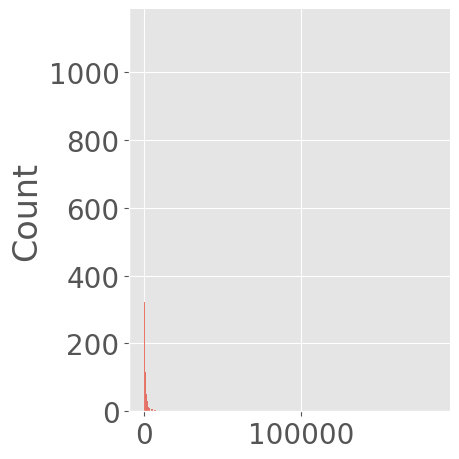

In [ ]:
# prompt: plot distribution of df_itemid_sequences['sequence_length']
df_labtest_sequences_pd_4 = df_itemid_sequences_4.to_pandas()
sns.displot(df_itemid_sequences_4['sequence_length'])


In [ ]:
print(df_itemid_sequences_4['sequence_length'].max())
print(df_itemid_sequences_4['sequence_length'].min())

185526


1


In [ ]:
print(df_itemid_sequences_4.dtypes)

subject_id                                   Int64
itemid_sequence                    string[pyarrow]
test_value_sequence    list<item: double>[pyarrow]
sequence_length                              Int64
icd_codes                          string[pyarrow]
data_source                        string[pyarrow]
label_ad                                     Int64
dtype: object


### **Similarly for MIMIC_III**

In [ ]:
query = """
    SELECT
        subject_id,
        STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
        ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
        ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
        STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) AS icd_codes,
        'mimic_iii' AS data_source,
        CASE WHEN STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) LIKE '%331%' THEN 1 ELSE 0 END AS label_ad
    FROM (
        SELECT
            d.subject_id,
            l.itemid,
            l.valuenum,
            l.charttime,
            d.icd9_code,
            ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime DESC) AS rn
        FROM
            `physionet-data.mimiciii_clinical.diagnoses_icd` AS d
        JOIN
            `physionet-data.mimiciii_clinical.labevents` AS l
        ON
            d.subject_id = l.subject_id
        JOIN
            `physionet-data.mimiciii_clinical.admissions` AS a
        ON
            l.hadm_id = a.hadm_id
        INNER JOIN
          `physionet-data.mimiciii_clinical.d_labitems` AS dlab
        ON
          l.itemid = dlab.itemid
        WHERE
            d.icd9_code LIKE '331%'  -- ICD-9 codes for Alzheimer's and related diseases
            AND l.valuenum IS NOT NULL
            AND l.charttime <= a.dischtime
            AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
            # AND LOWER(dlab.label) NOT LIKE '%csf%'
    ) AS filtered
    # WHERE
    #     rn <= 2  -- only keep the first two entries for each itemid per patient
    GROUP BY
        subject_id
    ORDER BY
        subject_id;
"""
df_itemid_sequences_3 = bf.read_gbq(query)
print(len(df_itemid_sequences_3))
df_itemid_sequences_3.head(10)

1246


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,31403,"51254,50970,51249,50882,51248,50993,51146,5096...",[3.600e+00 3.200e+00 3.170e+01 3.000e+01 2.640...,248,3310,mimic_iii,1
1,88008,"50882,50868,51222,51274,51237,51006,50983,5127...",[2.0000e+01 1.8000e+01 1.4100e+01 1.2600e+01 1...,755,3314,mimic_iii,1
2,11388,"51248,51006,51221,51277,51214,51301,51250,5086...",[3.050e+01 1.200e+01 3.980e+01 1.420e+01 3.170...,278,3313,mimic_iii,1
3,14129,"51244,51254,51146,50882,50902,50924,51277,5124...",[9.600e+00 1.700e+00 1.000e-01 2.400e+01 1.100...,138,3310,mimic_iii,1
4,17374,"51516,51514,51491,50931,50809,50868,50902,5091...",[0.000e+00 2.000e-01 5.000e+00 9.820e+02 9.800...,220,3310,mimic_iii,1
5,12713,"50971,51254,51265,51244,51003,51237,51279,5086...",[4.100e+00 8.000e+00 1.680e+02 1.590e+01 7.000...,609,3314,mimic_iii,1
6,76056,"51237,51275,51277,51274,51200,51250,51254,5097...",[1.100e+00 2.610e+01 1.330e+01 1.250e+01 6.000...,220,33182,mimic_iii,1
7,2708,"50911,51516,51492,51493,51491,51478,51498,5082...",[ 2.200e+01 4.300e+01 3.000e+01 2.000e+00 ...,382,3310,mimic_iii,1
8,8829,"51254,50931,51256,51251,51244,51277,51237,5114...",[ 7.000e+00 1.800e+02 9.200e+01 0.000e+00 ...,409,3310,mimic_iii,1
9,7367,"51237,51301,50868,51237,51254,50971,51256,5124...",[1.600e+00 6.100e+00 1.500e+01 1.400e+00 4.700...,134,33182,mimic_iii,1


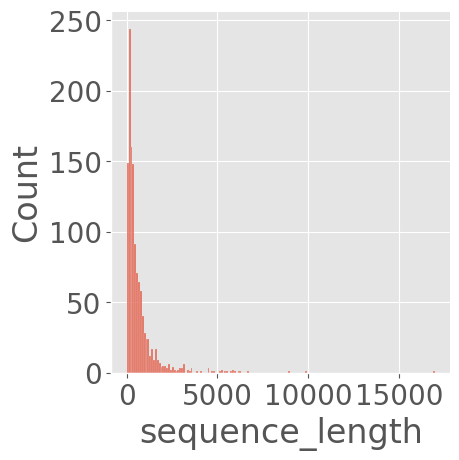

In [ ]:
df_labtest_sequences_pd_3 = df_itemid_sequences_3.to_pandas()
sns.displot(df_labtest_sequences_pd_3['sequence_length'])

In [ ]:
print(df_labtest_sequences_pd_3.head())

   subject_id                                    itemid_sequence  \
0       31403  51254,50970,51249,50882,51248,50993,51146,5096...   
1       88008  50882,50868,51222,51274,51237,51006,50983,5127...   
2       11388  51248,51006,51221,51277,51214,51301,51250,5086...   
3       14129  51244,51254,51146,50882,50902,50924,51277,5124...   
4       17374  51516,51514,51491,50931,50809,50868,50902,5091...   

                                 test_value_sequence  sequence_length  \
0  [3.600e+00 3.200e+00 3.170e+01 3.000e+01 2.640...              248   
1  [2.0000e+01 1.8000e+01 1.4100e+01 1.2600e+01 1...              755   
2  [3.050e+01 1.200e+01 3.980e+01 1.420e+01 3.170...              278   
3  [9.600e+00 1.700e+00 1.000e-01 2.400e+01 1.100...              138   
4  [0.000e+00 2.000e-01 5.000e+00 9.820e+02 9.800...              220   

  icd_codes data_source  label_ad  
0      3310   mimic_iii         1  
1      3314   mimic_iii         1  
2      3313   mimic_iii         1  
3      3

**Combine data fromo mimic iii and iv**

Skewness: 19.576489817698963


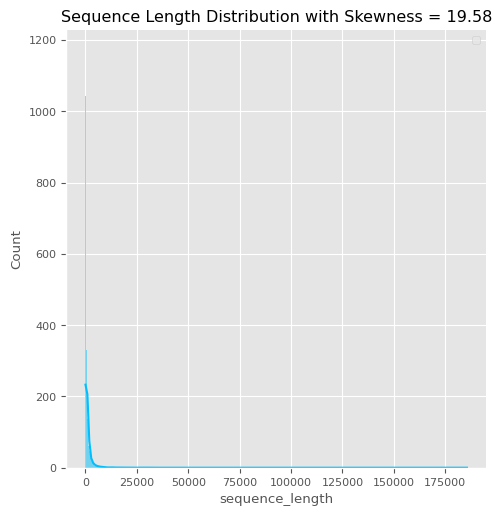

In [ ]:
# df_labtest_sequences_pd = df_itemid_sequences.to_pandas()
df_labtest_sequences_pd = pd.concat([df_labtest_sequences_pd_4, df_labtest_sequences_pd_3], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'font.size': 8})

sns.displot(df_labtest_sequences_pd['sequence_length'], kde=True, color='#00BFFF')

skewness = df_labtest_sequences_pd['sequence_length'].skew()
print(f'Skewness: {skewness}')

plt.title(f'Sequence Length Distribution with Skewness = {skewness:.2f}')

# sns.histplot(data, kde=True)

plt.legend()
plt.show()


**Split itemid sequences, save dataframe**

In [ ]:
import ast


df_labtest_sequences_pd['itemid_sequence'] = df_labtest_sequences_pd['itemid_sequence'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
# df_labtest_sequences_pd['test_value_sequence'] = df_labtest_sequences_pd['test_value_sequence'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
# df_labtest_sequences_pd.to_csv(file_path + 'df_labtest_sequences_pd.csv', index=False)

patients_itemid_seqs = df_labtest_sequences_pd['itemid_sequence']
patients_itemid_seqs[:1]

,itemid_sequence
0,"[51301, 50902, 50893, 50960, 51222, 51003, 512..."


In [ ]:
# df_labtest_sequences_pd = pd.read_csv('df_labtest_sequences_pd.csv')
print(len(df_labtest_sequences_pd))
df_labtest_sequences_pd.head(1)

7345


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,16270291,"[51301, 50902, 50893, 50960, 51222, 51003, 512...",[1.010e+01 1.000e+02 9.300e+00 1.700e+00 1.090...,66,2900,mimic_iv,0


## **Apply Word2vec embedding, treating each patient's test history as a "sentence" and each labtest as a "word".**

In [ ]:
# from gensim.models import Word2Vec

# w2v_model = Word2Vec(sentences=patients_itemid_seqs, vector_size=20, window=5, sg=1, workers=4, negative=5)
# labevent_vectors = w2v_model.wv
# labevent_ids = list(labevent_vectors.index_to_key)
# print(labevent_ids)
# vectors = np.array([labevent_vectors[code] for code in labevent_ids])

['50971', '50983', '50902', '50912', '51006', '50882', '50868', '50931', '51221', '51222', '51265', '51301', '51249', '51248', '51279', '51250', '51277', '50960', '50970', '50893', '50934', '50947', '51678', '52172', '51275', '51237', '51274', '50820', '50821', '50802', '50804', '50818', '50878', '50861', '50863', '50885', '50813', '51256', '51244', '51200', '51254', '51146', '51491', '51498', '50862', '50954', '50911', '50910', '51133', '52075', '52073', '52074', '52069', '51003', '50808', '51493', '52135', '51476', '51516', '50822', '51492', '50809', '51009', '50817', '50825', '50993', '50824', '50956', '51082', '51144', '51482', '51100', '50816', '51251', '51255', '51143', '51093', '50952', '50924', '50967', '50810', '50811', '50953', '50998', '51010', '50819', '50806', '51214', '50826', '50964', '51514', '51097', '51104', '50852', '50986', '50963', '51078', '51000', '51613', '51478', '51283', '50867', '50935', '50907', '50889', '51257', '50904', '50903', '50905', '51484', '50908', 

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings

labevent_ids = list(set([code for seq in patients_itemid_seqs for code in seq]))
vectors = np.array([get_embedding(str(code)).squeeze() for code in labevent_ids])

print(vectors.shape)


(502, 768)


Apply PCA to reform the dimensions

In [ ]:
pca = PCA(n_components=20)
vectors_pca = pca.fit_transform(vectors)



In [ ]:
print(len(vectors_pca))
print(vectors_pca)

502
[[ 1.6219109   0.14971976  0.695458   ... -0.22072573 -0.22783728
   0.07428312]
 [ 1.1353965   0.8450356  -0.4782573  ...  0.4748825  -0.30627847
   0.158902  ]
 [ 0.8180506   0.0953743  -0.2697036  ...  0.48568833 -0.3545477
   0.4270067 ]
 ...
 [ 0.01391686 -0.64352304 -1.1403724  ...  0.14527725 -0.13329057
   0.02843399]
 [ 0.09696224  1.5133487   0.5560402  ...  0.00401746  0.04017084
  -0.2679313 ]
 [ 2.422658   -0.43818244 -1.7799984  ... -0.58017343  0.15856272
   0.359783  ]]


In [ ]:
# check cumulative_variance_ratio
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance Ratio per Principal Component:")
print(explained_variance_ratio)


cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio:")
print(cumulative_variance_ratio)

Explained Variance Ratio per Principal Component:
[0.20478845 0.13936073 0.07793356 0.05659496 0.04853039 0.04107222
 0.03327609 0.02964417 0.02461977 0.02168976 0.02054347 0.01855835
 0.01683578 0.01527007 0.0137976  0.01215549 0.01138141 0.00964511
 0.00910132 0.00816308]
Cumulative Explained Variance Ratio:
[0.20478845 0.34414917 0.42208272 0.4786777  0.5272081  0.5682803
 0.60155636 0.63120055 0.6558203  0.6775101  0.69805354 0.71661186
 0.7334477  0.7487177  0.7625153  0.7746708  0.78605217 0.7956973
 0.8047986  0.8129617 ]


# **k-means for the embeded itemids**

eps = 0.1, min_samples = 3, Silhouette Score: -1
eps = 0.1, min_samples = 4, Silhouette Score: -1
eps = 0.1, min_samples = 5, Silhouette Score: -1
eps = 0.1, min_samples = 6, Silhouette Score: -1
eps = 0.1, min_samples = 7, Silhouette Score: -1
eps = 0.1, min_samples = 8, Silhouette Score: -1
eps = 0.1, min_samples = 9, Silhouette Score: -1
eps = 0.1, min_samples = 10, Silhouette Score: -1
eps = 0.1, min_samples = 11, Silhouette Score: -1
eps = 0.1, min_samples = 12, Silhouette Score: -1
eps = 0.1, min_samples = 13, Silhouette Score: -1
eps = 0.1, min_samples = 14, Silhouette Score: -1
eps = 0.1, min_samples = 15, Silhouette Score: -1
eps = 0.1, min_samples = 16, Silhouette Score: -1
eps = 0.1, min_samples = 17, Silhouette Score: -1
eps = 0.30000000000000004, min_samples = 3, Silhouette Score: -1
eps = 0.30000000000000004, min_samples = 4, Silhouette Score: -1
eps = 0.30000000000000004, min_samples = 5, Silhouette Score: -1
eps = 0.30000000000000004, min_samples = 6, Silhouette Score: 

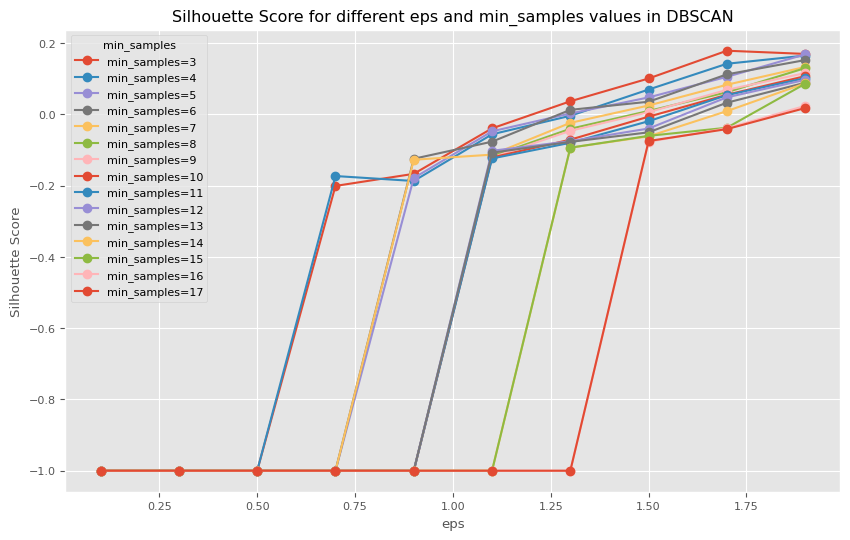

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

eps_values = np.arange(0.1, 2.0, 0.2)
min_samples_values = range(3, 18)

dbscan_silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(vectors_pca)

        if len(set(cluster_labels)) > 1 and len(set(cluster_labels) - {-1}) > 1:
            silhouette_avg = silhouette_score(vectors_pca, cluster_labels)
        else:
            silhouette_avg = -1

        dbscan_silhouette_scores.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette_avg
        })
        print(f"eps = {eps}, min_samples = {min_samples}, Silhouette Score: {silhouette_avg}")

import pandas as pd
df_silhouette = pd.DataFrame(dbscan_silhouette_scores)

# Step 4: Plotting the Silhouette Score for different eps and min_samples
plt.figure(figsize=(10, 6))

# Plot silhouette scores
for min_samples in min_samples_values:
    subset = df_silhouette[df_silhouette['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette_score'], marker='o', label=f'min_samples={min_samples}')

plt.title('Silhouette Score for different eps and min_samples values in DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.legend(title='min_samples')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd


# Step 2: Perform KMeans clustering on the original or PCA-reduced data
n_clusters = 24  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_pca)  # Perform clustering on PCA-reduced data

# Step 3: t-SNE to visualize the clusters
tsne = TSNE(n_components=3, random_state=42)
vectors_tsne = tsne.fit_transform(vectors_pca)

# Step 4: Query to get itemid and label
query = """
    SELECT
        itemid,
        label
    FROM
        `physionet-data.mimiciv_hosp.d_labitems`
"""

df_labitems = bf.read_gbq(query).to_pandas()
print(len(df_labitems))
print(df_labitems.head(1))

itemid_to_label = dict(zip(df_labitems['itemid'].astype(str), df_labitems['label']))

# Prepare itemid and label list for visualization
itemid_label_list = [f"{itemid}: {itemid_to_label.get(str(itemid), 'Unknown Label')}" for itemid in labevent_ids]

# Step 5: Plotting the clusters with different colors based on KMeans cluster labels
trace = go.Scatter3d(
    x=vectors_tsne[:, 0],
    y=vectors_tsne[:, 1],
    z=vectors_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster_labels,  # Color based on cluster labels from KMeans
        colorscale='Viridis',  # You can change the colorscale
        opacity=0.8
    ),
    text=itemid_label_list
)

data = [trace]

layout = go.Layout(
    title='3D t-SNE Visualization of Lab Event IDs with KMeans Clusters',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Step 6: Output itemid for each cluster
cluster_itemids = {i: [] for i in range(n_clusters)}  # Initialize a dictionary for each cluster

# Assign each itemid to its cluster
for idx, label in enumerate(cluster_labels):
    cluster_itemids[label].append(labevent_ids[idx])

# Output the itemids for each cluster
# for cluster, itemids in cluster_itemids.items():
#     print(f"Cluster {cluster}: {len(itemids)} items")
#     print(itemids)

1622
   itemid  label
0   52397  FL2-D


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd


# Step 1: Perform PCA for initial dimensionality reduction (optional, can skip if vectors are already in low dimensions)
pca = PCA(n_components=20)
vectors_pca = pca.fit_transform(vectors)  # Perform PCA first

# Step 2: t-SNE to reduce the dimensionality to 3 components for visualization
tsne = TSNE(n_components=3, random_state=42)
vectors_tsne = tsne.fit_transform(vectors_pca)  # Use PCA-reduced data for t-SNE

# Step 3: Perform KMeans clustering on the t-SNE reduced data
n_clusters = 24  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_tsne)  # Perform clustering on t-SNE-reduced data

# Step 4: Query to get itemid and label
query = """
    SELECT
        itemid,
        label
    FROM
        `physionet-data.mimiciv_hosp.d_labitems`
"""

df_labitems = bf.read_gbq(query).to_pandas()
print(len(df_labitems))
print(df_labitems.head(1))

itemid_to_label = dict(zip(df_labitems['itemid'].astype(str), df_labitems['label']))

# Prepare itemid and label list for visualization
itemid_label_list = [f"{itemid}: {itemid_to_label.get(str(itemid), 'Unknown Label')}" for itemid in labevent_ids]

# Step 5: Plotting the clusters with different colors based on KMeans cluster labels
trace = go.Scatter3d(
    x=vectors_tsne[:, 0],
    y=vectors_tsne[:, 1],
    z=vectors_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster_labels,  # Color based on cluster labels from KMeans
        colorscale='Viridis',  # You can change the colorscale
        opacity=0.9
    ),
    text=itemid_label_list
)

data = [trace]

layout = go.Layout(
    title='3D t-SNE Visualization of Lab Event IDs with KMeans Clusters',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Step 6: Output itemid for each cluster
cluster_itemids = {i: [] for i in range(n_clusters)}  # Initialize a dictionary for each cluster

# Assign each itemid to its cluster
for idx, label in enumerate(cluster_labels):
    cluster_itemids[label].append(labevent_ids[idx])

# Output the itemids for each cluster
# for cluster, itemids in cluster_itemids.items():
#     print(f"Cluster {cluster}: {len(itemids)} items")
#     print(itemids)


1622
   itemid  label
0   52397  FL2-D


In [ ]:
from sklearn.metrics import silhouette_score
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

silhouette_avg = silhouette_score(vectors_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Inertia: 1493.520751953125
Silhouette Score: 0.2511022388935089


In [ ]:
merged_df_sorted.head(5)

,itemid,count,label,fluid,category
70,50912,3729,Creatinine,Blood,Chemistry
130,51006,3728,Urea Nitrogen,Blood,Chemistry
107,50971,3727,Potassium,Blood,Chemistry
60,50902,3722,Chloride,Blood,Chemistry
46,50882,3722,Bicarbonate,Blood,Chemistry


In [ ]:
merged_df_sorted.dtypes

,0
itemid,object
count,int64
label,string[pyarrow]
fluid,string[pyarrow]
category,string[pyarrow]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd


# Step 1: Perform PCA for initial dimensionality reduction (optional, can skip if vectors are already in low dimensions)
pca = PCA(n_components=20)
vectors_pca = pca.fit_transform(vectors)  # Perform PCA first

# Step 2: t-SNE to reduce the dimensionality to 3 components for visualization
tsne = TSNE(n_components=3, random_state=42)
vectors_tsne = tsne.fit_transform(vectors_pca)  # Use PCA-reduced data for t-SNE

# Step 3: Perform KMeans clustering on the t-SNE reduced data
n_clusters = 24  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_tsne)  # Perform clustering on t-SNE-reduced data

# Step 4: Query to get itemid and label
query = """
    SELECT
        itemid,
        label
    FROM
        `physionet-data.mimiciv_hosp.d_labitems`
"""

df_labitems = bf.read_gbq(query).to_pandas()
print(len(df_labitems))
print(df_labitems.head(1))

itemid_to_label = dict(zip(df_labitems['itemid'].astype(str), df_labitems['label']))

# Prepare itemid and label list for visualization
itemid_label_list = [f"{itemid}: {itemid_to_label.get(str(itemid), 'Unknown Label')}" for itemid in labevent_ids]

1622
   itemid  label
0   52397  FL2-D


In [ ]:
# Step 5: Plotting the clusters with different colors based on KMeans cluster labels
trace = go.Scatter3d(
    x=vectors_tsne[:, 0],
    y=vectors_tsne[:, 1],
    z=vectors_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=cluster_labels,  # Color based on cluster labels from KMeans
        colorscale='Viridis',
        opacity=0.9
    ),
    text=itemid_label_list  # Hover text displaying itemid and label
)

# Add spheres for each cluster
def create_sphere(x, y, z, radius, resolution=20):
    """Generate the surface coordinates for a sphere centered at (x, y, z)."""
    phi, theta = np.mgrid[0:2 * np.pi:resolution*2j, 0:np.pi:resolution*1j]
    X = radius * np.sin(theta) * np.cos(phi)
    Y = radius * np.sin(theta) * np.sin(phi)
    Z = radius * np.cos(theta)
    return X + x, Y + y, Z + z

# Step 6: Add spheres for each cluster
sphere_traces = []
for i in range(n_clusters):
    # Get the points that belong to the current cluster
    cluster_points = vectors_tsne[cluster_labels == i]

    # Calculate the center of the cluster
    center = cluster_points.mean(axis=0)

    # Set the radius based on the mean distance from the center
    radius = np.linalg.norm(cluster_points - center, axis=1).mean() * 1.5

    # Generate the sphere around the cluster center
    X, Y, Z = create_sphere(center[0], center[1], center[2], radius, resolution=30)

    # Add the sphere as a surface to the plot, disabling hover
    sphere_trace = go.Surface(
        x=X, y=Y, z=Z,
        opacity=0.15,  # Transparent spheres
        colorscale='Blues',
        showscale=False,
        hoverinfo='skip'  # Disable hover for spheres
    )
    sphere_traces.append(sphere_trace)

# Step 7: Combine scatter and sphere traces
data = sphere_traces + [trace]  # Spheres first, points last

# Step 8: Create layout and plot
layout = go.Layout(
    title='3D t-SNE Visualization of Lab Event IDs with KMeans Clusters',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    hovermode='closest'  # Ensure hover prioritizes points closest to the mouse
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Step 9: Output itemid for each cluster
cluster_itemids = {i: [] for i in range(n_clusters)}  # Initialize a dictionary for each cluster

# Assign each itemid to its cluster
for idx, label in enumerate(cluster_labels):
    cluster_itemids[label].append(labevent_ids[idx])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig.write_html(file_path + "labevent_embeddings_sphere.html")

In [ ]:
# Step 5: Plotting each cluster with different colors and aggregated hover text
data_without_spheres = []

# Create separate traces for each cluster
for i in range(n_clusters):
    # Filter points for the current cluster
    cluster_points = vectors_tsne[cluster_labels == i]

    # Prepare itemid and label list for visualization for the current cluster
    itemid_label_list = [f"{labevent_ids[idx]}: {itemid_to_label.get(str(labevent_ids[idx]), 'Unknown Label')}"
                         for idx in range(len(labevent_ids)) if cluster_labels[idx] == i]

    # Aggregate hovertext into a single string for each cluster
    aggregated_hovertext = "<br>".join(itemid_label_list)

    # Create a trace for this cluster
    trace = go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=f"rgb({(i * 50) % 255}, {(i * 80) % 255}, {(i * 120) % 255})",  # Different color for each cluster
            opacity=0.9
        ),
        name=f"Cluster {i}",  # Name of the cluster shown in the legend
        hovertext=aggregated_hovertext,  # Hover text shows all points in the cluster
        hoverinfo='text'  # Display hovertext on hover
    )

    # Append this trace to the list of traces
    data_without_spheres.append(trace)

# Create layout and plot
layout_without_spheres = go.Layout(
    title='3D t-SNE Visualization of Lab Event IDs with KMeans Clusters (Without Spheres)',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    showlegend=True,  # Enable the legend
    hovermode='closest'
)

fig_without_spheres = go.Figure(data=data_without_spheres, layout=layout_without_spheres)
iplot(fig_without_spheres)


In [ ]:
# Create a dictionary to store the hovertext for each cluster
cluster_hovertext = {}

# Loop over each cluster to collect hovertext for all points in that cluster
for i in range(n_clusters):
    # Prepare itemid and label list for the current cluster
    itemid_label_list = [f"{labevent_ids[idx]}: {itemid_to_label.get(str(labevent_ids[idx]), 'Unknown Label')}"
                         for idx in range(len(labevent_ids)) if cluster_labels[idx] == i]

    # Aggregate hovertext into a single string for each cluster
    aggregated_hovertext = "<br>".join(itemid_label_list)

    # Store the hovertext in the dictionary
    cluster_hovertext[f"Cluster {i}"] = aggregated_hovertext

# Convert to a DataFrame for better visualization
df_hovertext = pd.DataFrame.from_dict(cluster_hovertext, orient='index', columns=['Hovertext'])
df_hovertext
# Display the dataframe
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Cluster Hovertexts", dataframe=df_hovertext)


,Hovertext
Cluster 0,51297: Thrombin<br>51269: Promyelocytes<br>512...
Cluster 1,50957: Lithium<br>50870: Anti-Gliadin Antibody...
Cluster 2,"50995: Thyroxine (T4), Free<br>51795: Lactate ..."
Cluster 3,"51659: HPE3<br>51109: Urine Volume, Total<br>5..."
Cluster 4,"51063: Osmolality, Stool<br>51061: Bicarbonate..."
Cluster 5,51667: H. pylori IgG Ab Value<br>50967: Phenyt...
Cluster 6,51376: Macrophage<br>51516: WBC<br>51356: Unkn...
Cluster 7,52132: HIT-Ab Numerical Result<br>51011: Unkno...
Cluster 8,51118: Mesothelial Cell<br>51148: Blasts<br>51...
Cluster 9,50818: pCO2<br>50813: Lactate<br>51616: Epstei...


### **Visualize embedding with t-SNE**

In [ ]:
# import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# reduce to 3d using t-SNE
tsne = TSNE(n_components=3, random_state=42)
vectors_tsne = tsne.fit_transform(vectors_pca)



In [ ]:
query = """
    SELECT
        itemid,
        label
    FROM
        `physionet-data.mimiciv_hosp.d_labitems`
"""

df_labitems = bf.read_gbq(query).to_pandas()
print(len(df_labitems))
print(df_labitems.head(1))


1622
   itemid  label
0   52397  FL2-D


In [ ]:
# labevent_ids = list(labevent_vectors.index_to_key)
# itemid_to_label = dict(zip(df_labitems['itemid'], df_labitems['label']))
# print(itemid_to_label)

itemid_to_label = dict(zip(df_labitems['itemid'].astype(str), df_labitems['label']))

itemid_label_list = [f"{itemid}: {itemid_to_label.get(str(itemid), 'Unknown Label')}" for itemid in labevent_ids]

trace = go.Scatter3d(
    x=vectors_tsne[:, 0],
    y=vectors_tsne[:, 1],
    z=vectors_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color='rgba(255, 128, 2, 0.8)',  # Marker color
    ),
    text=itemid_label_list
)

data = [trace]

layout = go.Layout(
    title='3D t-SNE Visualization of Lab Event IDs',
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)


**save**

In [ ]:
fig.write_html(file_path + "labevent_embeddings.html")

In [ ]:
# create a dict to convert itemid to embedding vector
itemid_to_vector = {str(itemid): vector for itemid, vector in zip(labevent_ids, vectors_pca)}
print(len(itemid_to_vector))

df_itemid_to_vector = pd.DataFrame.from_dict(itemid_to_vector, orient='index')
df_itemid_to_vector.reset_index(inplace=True)

df_itemid_to_vector.columns = ['itemid'] + [f'vector_{i}' for i in range(df_itemid_to_vector.shape[1] - 1)]
print(len(df_itemid_to_vector))
df_itemid_to_vector.head(1)


502
502


,itemid,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,...,vector_10,vector_11,vector_12,vector_13,vector_14,vector_15,vector_16,vector_17,vector_18,vector_19
0,51735,1.621916,0.149717,0.695458,-0.874585,-0.423603,-0.567098,-0.270054,0.008114,-1.044646,...,-0.56414,-0.486858,0.607975,-0.190866,0.118577,0.153755,-0.936731,-0.220527,-0.227966,0.075255


In [ ]:
# df_itemid_to_vector.to_csv(file_path + 'itemid_to_vector_2.csv', index=False)
# df_itemid_to_vector.to_csv(file_path + 'itemid_to_vector_all.csv', index=False)